In [2]:
import pandas as pd
import numpy as np
import re
import gensim
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud
from gensim import corpora, models, similarities
import pyLDAvis
from pprint import pprint
import pickle 
import os
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
import random
from gensim.models.ldamodel import LdaModel
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import MmCorpus
import csv
import pyLDAvis.gensim_models as gensimvis
RANDOM_STATE = 1

In [3]:
data = pd.read_csv('dataset/DatasetLegal.csv')
# train_data = pd.read_csv('model/train_data.csv')
# test_data = pd.read_csv('model/test_data.csv')
with open("model/train_data.csv", 'r') as f:
  train_data_csv = csv.reader(f)
  train_data = [i for i in train_data_csv]
with open("model/test_data.csv", 'r') as f:
  test_data_csv = csv.reader(f)
  test_data = [i for i in test_data_csv]
with open('model/id2word.pkl', 'rb') as f:
    id2word = pickle.load(f)

In [4]:
corpus = []
for text in train_data:
  vec = id2word.doc2bow(text)
  corpus.append(vec)
pd.Series(corpus)

test_corpus = []
for text in test_data:
  vec = id2word.doc2bow(text)
  test_corpus.append(vec)
pd.Series(test_corpus)

0       [(41, 2), (75, 2), (107, 1), (116, 1), (148, 2...
1       [(4, 2), (5, 1), (29, 1), (77, 6), (147, 1), (...
2       [(33, 2), (88, 1), (108, 1), (116, 2), (130, 2...
3       [(5, 2), (10, 1), (20, 4), (22, 1), (28, 1), (...
4       [(10, 1), (21, 1), (33, 2), (40, 1), (41, 1), ...
                              ...                        
2807    [(294, 1), (325, 1), (343, 1), (350, 1), (583,...
2808           [(219, 1), (764, 1), (3479, 1), (9614, 1)]
2809    [(20, 5), (27, 1), (28, 7), (34, 2), (40, 2), ...
2810    [(232, 1), (262, 1), (504, 1), (746, 2), (1010...
2811    [(154, 1), (504, 1), (724, 1), (734, 1), (746,...
Length: 2812, dtype: object

In [5]:
import logging
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

In [6]:
from gensim.models.callbacks import PerplexityMetric, CoherenceMetric
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = train_data)

In [7]:
num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            iterations=1000, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=0, # frequency of parameter updates during training.
                                            minimum_probability=0, 
                                            eval_every=1,
                                            callbacks=[perplexity_logger, coherence_cv_logger]
                                            )
# with open('model/lda_model.pkl', 'wb') as f:
#     pickle.dump(lda_model, f)
# lda_model.show_topics(num_topics=num_topics, num_words=10)

In [8]:
with open('model/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

In [51]:
iterations = [50, 100, 500, 1000, 3000]
for iteration in iterations:
    logging.debug(f'Start of model: {iteration} iterations')
    model = models.ldamodel.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=num_topics,
                                    iterations=iteration,
                                    chunksize=len(corpus),
                                    passes=20,
                                    alpha='auto',
                                    eta='auto',
                                    random_state=RANDOM_STATE, 
                                    update_every=0,
                                    minimum_probability=0, 
                                    eval_every=1,
                                    callbacks=[perplexity_logger, coherence_cv_logger]
                                    )

    logging.debug(f'End of model: {iteration} iterations')

    # if not os.path.exists(f"./lda_model/lda_{iteration}i20p/"):
    #     os.makedirs(f"./lda_model/lda_{iteration}i20p/")

    # model.save(f"lda_{iteration}i20p/lda_{iteration}i20p.model")

In [52]:
import re

log_file_path = "model_callbacks.log"
with open(log_file_path, 'r') as file:
    log_data = file.read()

perplexity_scores = re.findall(r'Perplexity estimate: (\d+\.\d+)', log_data)
perplexity_scores = [float(score) for score in perplexity_scores]

# Extract coherence scores
coherence_scores = re.findall(r'Coherence estimate: (\d+\.\d+)', log_data)
coherence_scores = [float(score) for score in coherence_scores]

# Print the extracted values
print("Perplexity:", perplexity_scores)
print("Coherence:", coherence_scores)

Perplexity: [1318.0760884936483, 189.63205974039897, 172.72947611852868, 163.95484289084095, 159.01080515745772, 155.80544462127412, 153.5837993384879, 151.92762290295795, 150.6722762952176, 149.68230996440607, 148.88855295765893, 148.23285686468208, 147.69070593745792, 147.21499992415835, 146.8240812791298, 146.4896068758435, 146.20298003118276, 145.96758497506863, 145.7567256173214, 145.57879670546302, 1284.5308288407587, 184.7782192436713, 171.12468449583335, 163.55414790895657, 159.03519320837816, 156.07451684536525, 154.02226618811272, 152.5049093027915, 151.3505409423381, 150.4055295695092, 149.63046553059206, 148.97556984503495, 148.4050976800184, 147.91388655721536, 147.48757870065097, 147.1077317057642, 146.7653023413844, 146.47385370560372, 146.2040110326071, 145.96725831110905, 1264.7876834583874, 182.2723056825835, 170.24071803910147, 163.24508549571746, 158.9726218035817, 156.12420693725463, 154.15893112026325, 152.71103462443685, 151.5693778014762, 150.64683887888253, 149

In [86]:
c = [0.5586380873755198, 0.38599867409067884, 0.478452336128274, 0.5109263894125088, 0.5229031268646563, 0.5441082099123954, 0.545848596169001, 0.545848596169001, 0.5705699556816013, 0.5705699556816013, 0.5934277799611439, 0.5934277799611439, 0.5934277799611439, 0.5918015420616523, 0.5933598818206666, 0.6112528250730361, 0.6112528250730361, 0.6112528250730361, 0.6026540843117649, 0.6026540843117649, 0.5586380873755198, 0.4067646735530277, 0.4894959300737792, 0.514332049888596, 0.5130571834038565, 0.5347280858770885, 0.5536889798816239, 0.5557980130984544, 0.5747868493794845, 0.585908441943674, 0.5909134752094093, 0.6027453238445056, 0.6027453238445056, 0.601119085945014, 0.6018616818934486, 0.6018616818934486, 0.5968065753273875, 0.6115744436547715, 0.6115744436547715, 0.6031774029071856, 0.5586380873755198, 0.39921696401600765, 0.4833707417710859, 0.514332049888596, 0.5175545044583502, 0.5291106243006188, 0.5407148879983423, 0.5533045681793332, 0.5991897422585497, 0.6040346995373248, 0.5967236034369461, 0.6085554520720424, 0.6027226671331006, 0.6027226671331006, 0.5943256263855147, 0.5943256263855147, 0.5943256263855147, 0.6090934947128988, 0.6090934947128988, 0.6090934947128988, 0.5586380873755198, 0.3953409423901217, 0.4833707417710859, 0.514332049888596, 0.524557167481825, 0.5291106243006188, 0.5516572554838168, 0.5646313473670985, 0.5991897422585497, 0.6040346995373248, 0.5967236034369461, 0.6085554520720424, 0.5979321977635889, 0.5979321977635889, 0.589535157016003, 0.589535157016003, 0.6090934947128988, 0.6090934947128988, 0.6090934947128988, 0.6090934947128988, 0.5586380873755198, 0.3953409423901217, 0.4833707417710859, 0.514332049888596, 0.524557167481825, 0.5291106243006188, 0.5516572554838168, 0.5595219110610791, 0.5971648729751441, 0.6040346995373248, 0.597954854474994, 0.5979321977635889, 0.5979321977635889, 0.5979321977635889, 0.589535157016003, 0.589535157016003, 0.6043030253433871, 0.6043030253433871, 0.6043030253433871, 0.6092089685892926]
print(c.index(max(c))) # 17 passes 100 iteration
print(max(c))

37
0.6115744436547715


In [56]:
perplexity_50i = perplexity_scores[1:20]
perplexity_100i = perplexity_scores[21:40]
perplexity_500i = perplexity_scores[41:60]
perplexity_1000i = perplexity_scores[61:80]
perplexity_3000i = perplexity_scores[81:100]

coherence_50i = coherence_scores[:20]
coherence_100i = coherence_scores[20:40]
coherence_500i = coherence_scores[40:60]
coherence_1000i = coherence_scores[60:80]
coherence_3000i = coherence_scores[80:100]
print(perplexity_50i)
print(perplexity_1000i)
print(coherence_50i)
print(coherence_1000i)

[189.63205974039897, 172.72947611852868, 163.95484289084095, 159.01080515745772, 155.80544462127412, 153.5837993384879, 151.92762290295795, 150.6722762952176, 149.68230996440607, 148.88855295765893, 148.23285686468208, 147.69070593745792, 147.21499992415835, 146.8240812791298, 146.4896068758435, 146.20298003118276, 145.96758497506863, 145.7567256173214, 145.57879670546302]
[182.20975733461097, 170.24416280428892, 163.26453370202645, 159.0033655443571, 156.1619252403597, 154.1977995794533, 152.75120927705655, 151.59670706190764, 150.67599204542765, 149.903988715153, 149.2287711767095, 148.6358746165975, 148.11441941648562, 147.64672800978323, 147.21939227923787, 146.83969791803978, 146.49363984946405, 146.1919905696213, 145.907582107691]
[0.5586380873755198, 0.38599867409067884, 0.478452336128274, 0.5109263894125088, 0.5229031268646563, 0.5441082099123954, 0.545848596169001, 0.545848596169001, 0.5705699556816013, 0.5705699556816013, 0.5934277799611439, 0.5934277799611439, 0.593427779961

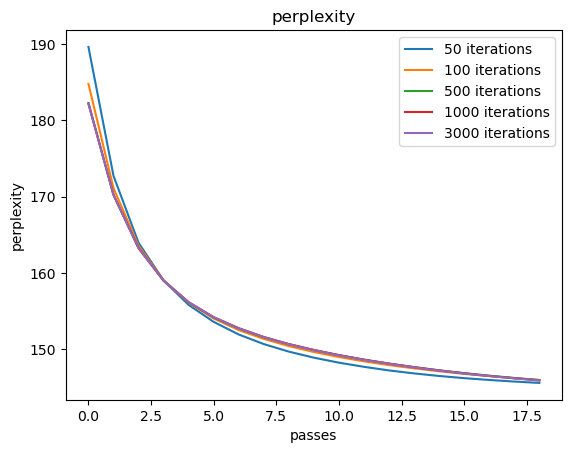

In [66]:
x = range(19)
plt.plot(x, perplexity_50i, label = "50 iterations")
plt.plot(x, perplexity_100i, label = "100 iterations")
plt.plot(x, perplexity_500i, label = "500 iterations")
plt.plot(x, perplexity_1000i, label = "1000 iterations")
plt.plot(x, perplexity_3000i, label = "3000 iterations")
plt.ylabel('perplexity')
plt.xlabel('passes')
plt.title('perplexity')
plt.legend()
plt.show()

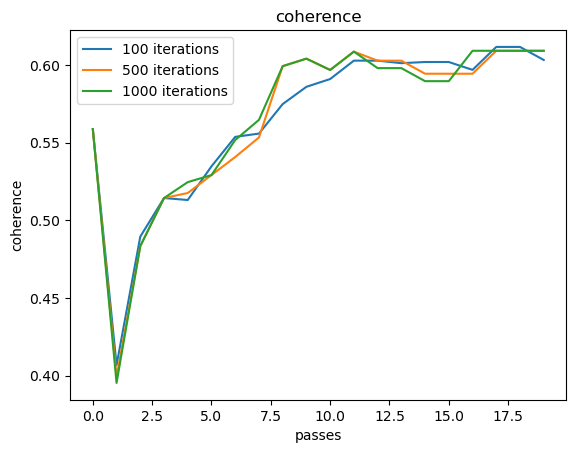

In [71]:
x = range(20)
# plt.plot(x, coherence_50i, label = "50 iterations")
plt.plot(x, coherence_100i, label = "100 iterations")
plt.plot(x, coherence_500i, label = "500 iterations")
plt.plot(x, coherence_1000i, label = "1000 iterations")
# plt.plot(x, coherence_3000i, label = "3000 iterations")
plt.xlabel('passes')
plt.ylabel('coherence')
plt.title('coherence')
plt.legend()
plt.show()

In [ ]:
# num_topics = range(4, 10)

# alpha_values = [0.01, 0.1, 0.5, 0.9]

# beta_values = [0.01, 0.1, 0.5, 0.9]

# # Initialize lists to store coherence scores and model parameters
# coherence_scores = []
# coherence_per_topic = []
# topic_params = []
# alpha_params = []
# beta_params = []

# # Loop over different combinations of topic, alpha, and beta parameter values
# for t in num_topics:
#     sub_coherence_per_topic = []
#     sub_coherence_score = []
#     for a in alpha_values:
#         for b in beta_values:
#             lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                                         id2word=id2word,
#                                                         num_topics=t,
#                                                         iterations=100,
#                                                         chunksize=200,
#                                                         passes=5,
#                                                         alpha=a,
#                                                         eta=b)
#             coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_answer, dictionary=id2word, coherence='c_v')
#             coherence_score = coherence_model_lda.get_coherence()
#             per_topic = coherence_model_lda.get_coherence_per_topic()
            
#             sub_coherence_per_topic.append(per_topic)
#             sub_coherence_score.append(coherence_score)
#             coherence_scores.append(coherence_score)
#             topic_params.append(t)
#             alpha_params.append(a)
#             beta_params.append(b)
#     coherence_per_topic.append(sub_coherence_per_topic[sub_coherence_score.index(max(sub_coherence_score))])

In [77]:
num_topics = range(4,11)
coherence_scores = []
topic_params = []
coherence_per_topic = []
perplexity_scores = []

for t in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                                id2word=id2word, # bow
                                                num_topics=t,
                                                iterations=500, # number of iterations performed within each pass
                                                chunksize=len(corpus),
                                                passes=10, # number of times the model goes through the entire training corpus
                                                alpha='auto', # how sparse of topic distribution
                                                eta='auto', # how sparse of word distribution
                                                random_state=RANDOM_STATE, 
                                                update_every=0, # frequency of parameter updates during training.
                                                minimum_probability=0, 
                                                eval_every=1,
                                                callbacks=[perplexity_logger, coherence_cv_logger]
                                                )
            
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v')
    coherence_per_topic.append(coherence_model_lda.get_coherence_per_topic())
    coherence_scores.append(coherence_model_lda.get_coherence())
    perplexity = lda_model.log_perplexity(test_corpus)
    perplexity_scores.append(perplexity)

In [81]:
coherence_scores

[0.48836984403522743,
 0.49548335270298505,
 0.4847755851228361,
 0.5311607606762675,
 0.5093421940006315,
 0.48172089343601043,
 0.4895152536811872]

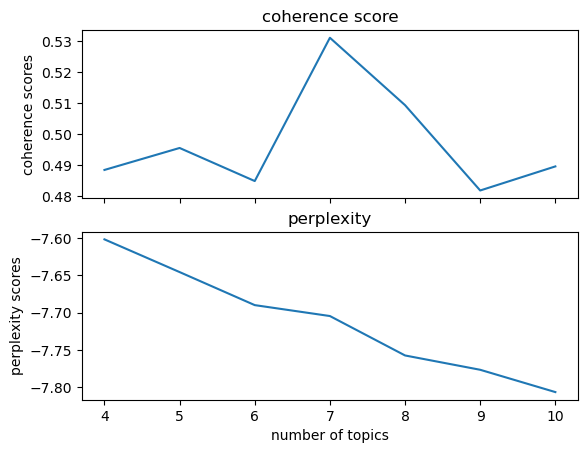

In [80]:
x = num_topics
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(x, coherence_scores)
# ax[0].set_xlabel('number of topics')
ax[0].set_ylabel('coherence scores')
ax[0].set_title('coherence score')
ax[1].plot(x, perplexity_scores)
ax[1].set_xlabel('number of topics')
ax[1].set_ylabel('perplexity scores')
ax[1].set_title('perplexity')
plt.show()

Text(0, 0.5, 'coherence score')

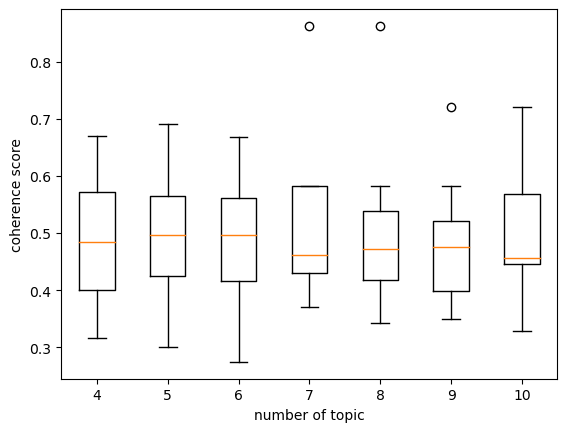

In [87]:
plt.boxplot(coherence_per_topic)
plt.xticks(range(1, 8), range(4, 11))
plt.xlabel('number of topic')
plt.ylabel('coherence score')

In [7]:
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=500, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=0, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            # eval_every=1
                                            )

CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.029*"รถ" + 0.022*"เงิน" + 0.017*"จ่าย" + 0.014*"บริษัท" + 0.013*"บาท" + 0.011*"คืน" + 0.011*"โอน" + 0.010*"ขาย" + 0.009*"สัญญา" + 0.009*"เพื่อน"'),
 (1,
  '0.034*"ศาล" + 0.025*"จำเลย" + 0.015*"มาตรา" + 0.014*"บาท" + 0.012*"จำคุก" + 0.011*"ความผิด" + 0.009*"เช็ค" + 0.009*"กระทำความผิด" + 0.009*"โจทก์" + 0.008*"อุทธรณ์"'),
 (2,
  '0.036*"ที่ดิน" + 0.025*"บุตร" + 0.017*"สามี" + 0.017*"พ่อ" + 0.015*"แม่" + 0.015*"บ้าน" + 0.014*"สิทธิ" + 0.014*"ลูก" + 0.011*"บิดา" + 0.011*"แบ่ง"'),
 (3,
  '0.021*"บ้าน" + 0.021*"ธนาคาร" + 0.012*"แฟน" + 0.012*"บาท" + 0.010*"เงิน" + 0.010*"หนี้" + 0.008*"ฟ้อง" + 0.008*"แม่" + 0.007*"ลูก" + 0.007*"โดน"'),
 (4,
  '0.024*"ตำรวจ" + 0.016*"โดน" + 0.011*"ศาล" + 0.008*"ทราบ" + 0.008*"แฟน" + 0.008*"แจ้งความ" + 0.007*"ข้อหา" + 0.007*"จำหน่าย" + 0.007*"เพื่อน" + 0.007*"ยา"'),
 (5,
  '0.014*"สัญญา" + 0.013*"ผู้ขาย" + 0.011*"ที่ดิน" + 0.011*"ผู้ซื้อ" + 0.009*"มาตรา" + 0.009*"ซื้อ" + 0.008*"ขาย" + 0.008*"กรณี" + 0.008*"สินค้า" + 0.007*"ยกเลิก"'),
 (6,
  '0.026*"ส

In [8]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.121780 -0.205631       1        1  19.404442
8      0.026888  0.180715       2        1  14.663618
0     -0.047956 -0.000111       3        1  14.124994
3     -0.109268 -0.081860       4        1  11.009399
1     -0.039507  0.017465       5        1  10.749510
9      0.159716  0.051000       6        1   9.064783
4     -0.181598 -0.031205       7        1   7.763643
6      0.108468 -0.072509       8        1   5.726790
7     -0.125502  0.030062       9        1   4.727243
5      0.086979  0.112073      10        1   2.765576, topic_info=        Term         Freq        Total Category  logprob  loglift
651  นายจ้าง  3310.000000  3310.000000  Default  30.0000  30.0000
232   ที่ดิน  4629.000000  4629.000000  Default  29.0000  29.0000
653  ลูกจ้าง  2611.000000  2611.000000  Default  28.0000  28.0000
33      สามี  2955.000000  2955.000000  Default  27.0000  27.0000
93      บุตร  2975.000000  2975.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
115     ตกลง    60.961735  1457.116185  Topic10  -5.5290   0.4140
148     จ่าย    67.175841  4024.645830  Topic10  -5.4320  -0.5050
448     บ้าน    63.774405  3931.841797  Topic10  -5.4839  -0.5336
202      ตอบ    52.942604  1353.177219  Topic10  -5.6701   0.3469
164     ฟ้อง    53.571510  3744.829832  Topic10  -5.6583  -0.6592

[795 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
11473      5  0.884076       '
0          1  0.197775  กฎหมาย
0          2  0.221128  กฎหมาย
0          3  0.060573  กฎหมาย
0          4  0.023353  กฎหมาย
...      ...       ...     ...
7194      10  0.873618    ๒๕๑๘
4915       2  0.155060    ๒๕๒๒
4915       8  0.022151    ๒๕๒๒
4915       9  0.797452    ๒๕๒๒
1547       6  0.898250     ๖๕๓

[3292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 1, 4, 2, 10, 5, 7, 8, 6])

In [6]:
num_topics = 9
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=500, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=0, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            # eval_every=1
                                            )

CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.025*"รถ" + 0.024*"เงิน" + 0.016*"จ่าย" + 0.014*"บริษัท" + 0.013*"บาท" + 0.011*"สัญญา" + 0.011*"คืน" + 0.010*"โอน" + 0.009*"เพื่อน" + 0.009*"ขาย"'),
 (1,
  '0.034*"ศาล" + 0.024*"จำเลย" + 0.014*"มาตรา" + 0.013*"บาท" + 0.011*"จำคุก" + 0.011*"ความผิด" + 0.010*"เช็ค" + 0.009*"โจทก์" + 0.009*"กระทำความผิด" + 0.008*"ฟ้อง"'),
 (2,
  '0.034*"ที่ดิน" + 0.024*"บุตร" + 0.018*"สามี" + 0.017*"พ่อ" + 0.016*"บ้าน" + 0.016*"แม่" + 0.015*"ลูก" + 0.013*"สิทธิ" + 0.011*"ภรรยา" + 0.010*"บิดา"'),
 (3,
  '0.023*"ธนาคาร" + 0.018*"เจ้าหนี้" + 0.016*"บ้าน" + 0.016*"หนี้" + 0.013*"ชำระหนี้" + 0.013*"ลูกหนี้" + 0.011*"บาท" + 0.011*"ฟ้อง" + 0.010*"เงิน" + 0.009*"ยึด"'),
 (4,
  '0.022*"ตำรวจ" + 0.017*"โดน" + 0.010*"แฟน" + 0.009*"ศาล" + 0.008*"ทราบ" + 0.008*"แจ้งความ" + 0.007*"เพื่อน" + 0.007*"ข้อหา" + 0.007*"จำหน่าย" + 0.006*"ซื้อ"'),
 (5,
  '0.039*"สัญญา" + 0.021*"มาตรา" + 0.019*"เช่าซื้อ" + 0.017*"สิทธิ" + 0.013*"ปพพ" + 0.013*"ชำระหนี้" + 0.012*"รับผิด" + 0.011*"กู้ยืม" + 0.010*"บังคับ" + 0.010*"กรณี"')

In [7]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.186889 -0.132609       1        1  20.620933
0     -0.038017  0.007066       2        1  14.917819
8     -0.020461  0.218795       3        1  14.857440
1     -0.048461 -0.022284       4        1  11.379099
3     -0.049453 -0.067082       5        1  10.485656
4     -0.157485 -0.093146       6        1   8.558170
5      0.107514  0.108036       7        1   7.641235
6      0.141058 -0.013082       8        1   6.614901
7     -0.121585 -0.005693       9        1   4.924747, topic_info=        Term         Freq        Total Category  logprob  loglift
651  นายจ้าง  3305.000000  3305.000000  Default  30.0000  30.0000
653  ลูกจ้าง  2608.000000  2608.000000  Default  29.0000  29.0000
232   ที่ดิน  4687.000000  4687.000000  Default  28.0000  28.0000
77     สัญญา  3443.000000  3443.000000  Default  27.0000  27.0000
93      บุตร  3003.000000  3003.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
262     ทราบ   126.178115  2582.327660   Topic9  -5.3786  -0.0079
339      แฟน   108.552878  1639.424173   Topic9  -5.5291   0.2960
237     ยื่น    95.420552  1092.855635   Topic9  -5.6580   0.5726
845  พนักงาน    86.745061  1506.263070   Topic9  -5.7533   0.1565
264    ทำงาน    85.122298  2389.116240   Topic9  -5.7722  -0.3237

[722 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
11473      4  0.887581       '
0          1  0.203302  กฎหมาย
0          2  0.070179  กฎหมาย
0          3  0.230795  กฎหมาย
0          4  0.133847  กฎหมาย
...      ...       ...     ...
8393       8  0.899936    ๒๔๘๓
4915       3  0.132951    ๒๕๒๒
4915       6  0.088634    ๒๕๒๒
4915       8  0.022159    ๒๕๒๒
4915       9  0.731233    ๒๕๒๒

[2881 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 9, 2, 4, 5, 6, 7, 8])

In [4]:
num_topics = 8
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=500, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=0, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            # eval_every=1
                                              )

CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.029*"บริษัท" + 0.023*"เงิน" + 0.019*"รถ" + 0.018*"จ่าย" + 0.013*"สัญญา" + 0.011*"บาท" + 0.010*"แจ้ง" + 0.009*"คืน" + 0.008*"ค่า" + 0.008*"โอน"'),
 (1,
  '0.035*"ศาล" + 0.021*"จำเลย" + 0.014*"บาท" + 0.013*"มาตรา" + 0.010*"จำคุก" + 0.010*"ฟ้อง" + 0.009*"ความผิด" + 0.009*"เช็ค" + 0.008*"โจทก์" + 0.008*"เงิน"'),
 (2,
  '0.031*"ที่ดิน" + 0.022*"บุตร" + 0.021*"สามี" + 0.015*"พ่อ" + 0.014*"บ้าน" + 0.014*"แม่" + 0.013*"สิทธิ" + 0.013*"ลูก" + 0.012*"มาตรา" + 0.010*"ภรรยา"'),
 (3,
  '0.021*"ธนาคาร" + 0.018*"เจ้าหนี้" + 0.015*"บ้าน" + 0.014*"หนี้" + 0.013*"ลูกหนี้" + 0.012*"ชำระหนี้" + 0.011*"ฟ้อง" + 0.010*"เงิน" + 0.010*"บาท" + 0.009*"ยึด"'),
 (4,
  '0.021*"ตำรวจ" + 0.015*"โดน" + 0.010*"แฟน" + 0.009*"ศาล" + 0.008*"ทราบ" + 0.008*"เพื่อน" + 0.008*"แจ้งความ" + 0.007*"ข้อหา" + 0.007*"รถ" + 0.007*"ซื้อ"'),
 (5,
  '0.038*"สัญญา" + 0.023*"มาตรา" + 0.020*"เช่าซื้อ" + 0.018*"สิทธิ" + 0.013*"ปพพ" + 0.012*"รับผิด" + 0.012*"ชำระหนี้" + 0.010*"บังคับ" + 0.010*"กู้ยืม" + 0.010*"กรณี"'),
 (6,
  '0.04

In [5]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.058379  0.229368       1        1  24.354872
0      0.022062 -0.023383       2        1  16.191445
1      0.031526 -0.010461       3        1  13.241713
3      0.098360  0.064017       4        1  11.905150
6     -0.159387 -0.126179       5        1  11.206709
4      0.168838 -0.022106       6        1   8.850859
5     -0.173510  0.002448       7        1   7.636216
7      0.070490 -0.113704       8        1   6.613035, topic_info=        Term         Freq        Total Category  logprob  loglift
651  นายจ้าง  3257.000000  3257.000000  Default  30.0000  30.0000
653  ลูกจ้าง  2567.000000  2567.000000  Default  29.0000  29.0000
77     สัญญา  3395.000000  3395.000000  Default  28.0000  28.0000
93      บุตร  3071.000000  3071.000000  Default  27.0000  27.0000
232   ที่ดิน  4753.000000  4753.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
41      เงิน   147.768294  4650.826217   Topic8  -5.5154  -0.7330
164     ฟ้อง   121.941604  3719.854526   Topic8  -5.7075  -0.7018
191     เวลา   108.865400  1281.857528   Topic8  -5.8210   0.2502
23     รบกวน   106.080280  1172.529505   Topic8  -5.8469   0.3134
328  ไม่ต้อง   104.968569   952.810181   Topic8  -5.8574   0.5104

[636 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
11473      3  0.893334       '
0          1  0.250881  กฎหมาย
0          2  0.078310  กฎหมาย
0          3  0.152994  กฎหมาย
0          4  0.029729  กฎหมาย
...      ...       ...     ...
4915       8  0.720733    ๒๕๒๒
3310       2  0.020878    ๒๕๔๑
3310       5  0.960399    ๒๕๔๑
5874       5  0.957147      ๔๙
1547       2  0.882666     ๖๕๓

[2427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 7, 5, 6, 8])

In [12]:
num_topics = 7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=500, # number of iterations performed within each pass
                                            chunksize=2000,
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            # update_every=0, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            eval_every=1
                                            )
lda_model.show_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.046*"บริษัท" + 0.017*"ทำงาน" + 0.017*"แจ้ง" + 0.014*"วันที่" + 0.014*"จ่าย" + 0.011*"งาน" + 0.010*"พนักงาน" + 0.010*"เงิน" + 0.009*"สัญญา" + 0.008*"เงินเดือน"'),
 (1,
  '0.045*"ศาล" + 0.018*"จำเลย" + 0.016*"มาตรา" + 0.012*"ความผิด" + 0.012*"ฟ้อง" + 0.010*"จำคุก" + 0.009*"กระทำความผิด" + 0.009*"คำพิพากษา" + 0.009*"ฐาน" + 0.009*"เช็ค"'),
 (2,
  '0.038*"ที่ดิน" + 0.024*"บุตร" + 0.021*"สามี" + 0.019*"พ่อ" + 0.016*"ลูก" + 0.016*"แม่" + 0.014*"สิทธิ" + 0.013*"มาตรา" + 0.013*"ภรรยา" + 0.012*"บ้าน"'),
 (3,
  '0.025*"บ้าน" + 0.024*"รถ" + 0.023*"เงิน" + 0.019*"บาท" + 0.016*"ธนาคาร" + 0.015*"จ่าย" + 0.013*"เพื่อน" + 0.011*"แฟน" + 0.011*"ซื้อ" + 0.010*"รบกวน"'),
 (4,
  '0.025*"ตำรวจ" + 0.023*"โดน" + 0.014*"แฟน" + 0.011*"ศาล" + 0.010*"ประกันตัว" + 0.009*"ข้อหา" + 0.009*"จำหน่าย" + 0.009*"ทราบ" + 0.008*"ยา" + 0.007*"ตัดสิน"'),
 (5,
  '0.041*"สัญญา" + 0.026*"ชำระหนี้" + 0.025*"เจ้าหนี้" + 0.020*"ลูกหนี้" + 0.019*"เช่าซื้อ" + 0.018*"เงิน" + 0.017*"ฟ้อง" + 0.017*"บังคับ" + 0.015*"สิทธิ" + 0.0

In [17]:
CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()

0.528739575914476

In [15]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.001339  0.248863       1        1  25.227782
0      0.016252 -0.068233       2        1  18.101355
1      0.038930 -0.030053       3        1  13.990237
4      0.168697 -0.053510       4        1  12.352683
6     -0.177576 -0.058651       5        1  11.530355
3      0.096334 -0.017691       6        1  10.910166
5     -0.141299 -0.020724       7        1   7.887420, topic_info=          Term         Freq        Total Category  logprob  loglift
651    นายจ้าง  3238.000000  3238.000000  Default  30.0000  30.0000
653    ลูกจ้าง  2547.000000  2547.000000  Default  29.0000  29.0000
77       สัญญา  3354.000000  3354.000000  Default  28.0000  28.0000
232     ที่ดิน  4748.000000  4748.000000  Default  27.0000  27.0000
93        บุตร  3073.000000  3073.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
441      ต่อไป   228.210123  1430.799640   Topic7  -5.2570   0.7042
191       เวลา   212.729429  1280.327863   Topic7  -5.3273   0.7451
62   ตามกฎหมาย   209.892706  1308.149259   Topic7  -5.3407   0.7101
219    หลักฐาน   205.157547  1053.164622   Topic7  -5.3635   0.9041
147        ค่า   206.143536  1805.157165   Topic7  -5.3587   0.3701

[570 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.253898  กฎหมาย
0         2  0.089483  กฎหมาย
0         3  0.171691  กฎหมาย
0         4  0.031283  กฎหมาย
0         5  0.234256  กฎหมาย
...     ...       ...     ...
3310      2  0.021041    ๒๕๔๑
3310      5  0.967880    ๒๕๔๑
5874      5  0.964181      ๔๙
7157      2  0.113348      ๖๖
7157      7  0.906785      ๖๖

[2065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 7, 4, 6])

In [9]:
num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=500, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=0, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            # eval_every=1
                                            )

CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=20)

[(0,
  '0.036*"บริษัท" + 0.018*"จ่าย" + 0.016*"เงิน" + 0.014*"ทำงาน" + 0.011*"สัญญา" + 0.011*"แจ้ง" + 0.010*"พนักงาน" + 0.009*"วันที่" + 0.008*"งาน" + 0.008*"นายจ้าง"'),
 (1,
  '0.029*"ศาล" + 0.016*"จำเลย" + 0.014*"บาท" + 0.011*"เงิน" + 0.010*"มาตรา" + 0.010*"ฟ้อง" + 0.009*"จำคุก" + 0.007*"ความผิด" + 0.007*"เช็ค" + 0.006*"จ่าย"'),
 (2,
  '0.031*"ที่ดิน" + 0.021*"บุตร" + 0.020*"สามี" + 0.014*"บ้าน" + 0.014*"พ่อ" + 0.013*"แม่" + 0.013*"สิทธิ" + 0.013*"มาตรา" + 0.012*"ลูก" + 0.009*"ภรรยา"'),
 (3,
  '0.017*"ธนาคาร" + 0.016*"เจ้าหนี้" + 0.014*"ชำระหนี้" + 0.013*"หนี้" + 0.012*"บ้าน" + 0.012*"ลูกหนี้" + 0.011*"ฟ้อง" + 0.010*"เงิน" + 0.008*"กู้" + 0.008*"บาท"'),
 (4,
  '0.015*"ตำรวจ" + 0.014*"โดน" + 0.011*"รถ" + 0.010*"แฟน" + 0.009*"ศาล" + 0.008*"เพื่อน" + 0.008*"ทราบ" + 0.006*"แจ้งความ" + 0.006*"ซื้อ" + 0.006*"ถาม"'),
 (5,
  '0.038*"นายจ้าง" + 0.035*"ลูกจ้าง" + 0.027*"มาตรา" + 0.022*"สิทธิ" + 0.018*"สัญญา" + 0.012*"จ่าย" + 0.012*"กรณี" + 0.011*"ค่าจ้าง" + 0.011*"เลิกจ้าง" + 0.010*"คุ้มครอง"'

In [19]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.065732 -0.230031       1        1  25.874804
0     -0.052884  0.059050       2        1  17.859331
1      0.028411  0.046768       3        1  16.594395
3      0.093282  0.027196       4        1  15.803097
5     -0.241936 -0.011332       5        1  12.016741
4      0.107395  0.108348       6        1  11.851632, topic_info=        Term         Freq        Total Category  logprob  loglift
651  นายจ้าง  3296.000000  3296.000000  Default  30.0000  30.0000
653  ลูกจ้าง  2591.000000  2591.000000  Default  29.0000  29.0000
232   ที่ดิน  4719.000000  4719.000000  Default  28.0000  28.0000
391   บริษัท  4347.000000  4347.000000  Default  27.0000  27.0000
93      บุตร  3057.000000  3057.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
384      ขาย   262.550046  1934.779032   Topic6  -5.5240   0.1354
148     จ่าย   288.253682  3947.284832   Topic6  -5.4306  -0.4842
448     บ้าน   279.144324  3941.736008   Topic6  -5.4628  -0.5149
17       บาท   251.632661  3097.080081   Topic6  -5.5665  -0.3775
539      รู้   238.903756  1158.463478   Topic6  -5.6184   0.5539

[483 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
11473      3  0.918755       '
0          1  0.274886  กฎหมาย
0          2  0.123553  กฎหมาย
0          3  0.185695  กฎหมาย
0          4  0.051907  กฎหมาย
...      ...       ...     ...
4121       3  0.008776    ไอซ์
4121       4  0.017553    ไอซ์
4121       6  0.956620    ไอซ์
3981       2  0.945561   ไอเทม
6149       5  0.904511     ๑๒๐

[1583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 6, 5])

In [14]:
num_topics = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=1000, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how sparse of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=0, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            eval_every=1
                                            )
CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=10)


[(0,
  '0.030*"บริษัท" + 0.028*"นายจ้าง" + 0.022*"ลูกจ้าง" + 0.017*"จ่าย" + 0.016*"ทำงาน" + 0.012*"สัญญา" + 0.011*"สิทธิ" + 0.010*"พนักงาน" + 0.010*"มาตรา" + 0.010*"งาน"'),
 (1,
  '0.023*"ศาล" + 0.014*"บาท" + 0.013*"เงิน" + 0.012*"จำเลย" + 0.011*"มาตรา" + 0.011*"ฟ้อง" + 0.009*"รถ" + 0.008*"สัญญา" + 0.008*"จ่าย" + 0.007*"จำคุก"'),
 (2,
  '0.030*"ที่ดิน" + 0.020*"บุตร" + 0.019*"สามี" + 0.013*"มาตรา" + 0.013*"บ้าน" + 0.013*"พ่อ" + 0.013*"สิทธิ" + 0.012*"แม่" + 0.011*"ลูก" + 0.009*"ภรรยา"'),
 (3,
  '0.014*"ธนาคาร" + 0.013*"เจ้าหนี้" + 0.012*"ชำระหนี้" + 0.011*"ลูกหนี้" + 0.010*"บ้าน" + 0.010*"หนี้" + 0.009*"เงิน" + 0.009*"ฟ้อง" + 0.008*"รถ" + 0.007*"บาท"'),
 (4,
  '0.014*"ตำรวจ" + 0.012*"โดน" + 0.009*"รถ" + 0.009*"ศาล" + 0.008*"แฟน" + 0.008*"ทราบ" + 0.007*"เพื่อน" + 0.006*"จ่าย" + 0.006*"แจ้ง" + 0.006*"ซื้อ"')]

In [18]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.221699  0.014862       1        1  26.902204
1      0.037242 -0.051727       2        1  23.050204
0      0.075587  0.175279       3        1  20.004142
3      0.017973 -0.062444       4        1  16.820155
4      0.090895 -0.075970       5        1  13.223296, topic_info=        Term         Freq        Total Category  logprob  loglift
651  นายจ้าง  3173.000000  3173.000000  Default  30.0000  30.0000
232   ที่ดิน  4681.000000  4681.000000  Default  29.0000  29.0000
653  ลูกจ้าง  2505.000000  2505.000000  Default  28.0000  28.0000
93      บุตร  3036.000000  3036.000000  Default  27.0000  27.0000
391   บริษัท  4159.000000  4159.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
17       บาท   311.718135  3147.672950   Topic5  -5.4619  -0.2891
804      คืน   276.906747  1703.102880   Topic5  -5.5803   0.2067
109   เอกสาร   259.904673  1395.937457   Topic5  -5.6437   0.3422
448     บ้าน   277.848322  3948.355909   Topic5  -5.5769  -0.6308
335       รอ   251.313971  1031.333923   Topic5  -5.6773   0.6113

[408 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.297994  กฎหมาย
0         2  0.270103  กฎหมาย
0         3  0.322949  กฎหมาย
0         4  0.052112  กฎหมาย
0         5  0.057250  กฎหมาย
...     ...       ...     ...
6166      4  0.940202    ไฮโซ
3309      3  0.964059     ๑๑๘
3310      3  0.980387    ๒๕๔๑
3310      5  0.021313    ๒๕๔๑
1120      4  0.938359     ๖๘๐

[1180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])

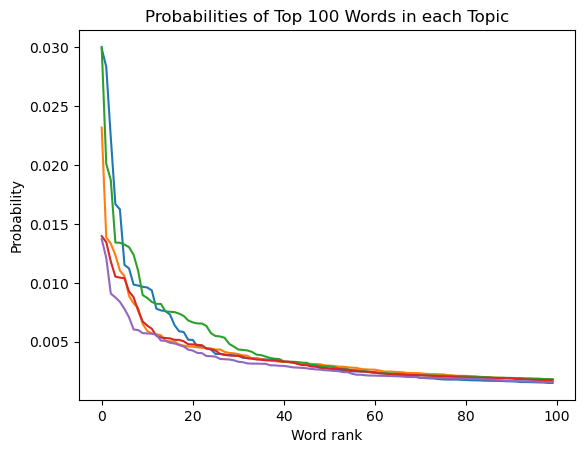

In [19]:
top_n_words = 100
topics = lda_model.show_topics(
    num_topics = num_topics, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')
# plt.legend()
plt.show()

In [6]:
num_topics = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=2000, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=2, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            eval_every=1
                                            )
CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.030*"บริษัท" + 0.028*"นายจ้าง" + 0.022*"ลูกจ้าง" + 0.017*"จ่าย" + 0.016*"ทำงาน" + 0.011*"สัญญา" + 0.011*"สิทธิ" + 0.010*"พนักงาน" + 0.010*"มาตรา" + 0.010*"งาน"'),
 (1,
  '0.023*"ศาล" + 0.014*"บาท" + 0.013*"เงิน" + 0.012*"จำเลย" + 0.011*"มาตรา" + 0.011*"ฟ้อง" + 0.009*"รถ" + 0.008*"สัญญา" + 0.008*"จ่าย" + 0.006*"จำคุก"'),
 (2,
  '0.030*"ที่ดิน" + 0.020*"บุตร" + 0.019*"สามี" + 0.013*"มาตรา" + 0.013*"บ้าน" + 0.013*"พ่อ" + 0.013*"สิทธิ" + 0.012*"แม่" + 0.011*"ลูก" + 0.009*"ภรรยา"'),
 (3,
  '0.014*"ธนาคาร" + 0.013*"เจ้าหนี้" + 0.012*"ชำระหนี้" + 0.010*"บ้าน" + 0.010*"ลูกหนี้" + 0.010*"หนี้" + 0.009*"เงิน" + 0.009*"ฟ้อง" + 0.008*"รถ" + 0.007*"บาท"'),
 (4,
  '0.014*"ตำรวจ" + 0.012*"โดน" + 0.009*"ศาล" + 0.009*"รถ" + 0.008*"แฟน" + 0.008*"ทราบ" + 0.007*"เพื่อน" + 0.006*"จ่าย" + 0.006*"แจ้ง" + 0.006*"ถาม"')]

In [7]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis/ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.221838  0.015205       1        1  26.876623
1      0.036792 -0.052225       2        1  23.040569
0      0.075805  0.175048       3        1  20.034484
3      0.017929 -0.063074       4        1  16.953646
4      0.091312 -0.074953       5        1  13.094678, topic_info=        Term         Freq        Total Category  logprob  loglift
651  นายจ้าง  3174.000000  3174.000000  Default  30.0000  30.0000
232   ที่ดิน  4678.000000  4678.000000  Default  29.0000  29.0000
653  ลูกจ้าง  2505.000000  2505.000000  Default  28.0000  28.0000
93      บุตร  3034.000000  3034.000000  Default  27.0000  27.0000
391   บริษัท  4161.000000  4161.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
17       บาท   309.751186  3147.954318   Topic5  -5.4585  -0.2858
804      คืน   268.131007  1702.776993   Topic5  -5.6028   0.1844
448     บ้าน   271.418778  3948.913679   Topic5  -5.5906  -0.6446
335       รอ   249.066479  1031.526231   Topic5  -5.6765   0.6119
109   เอกสาร   250.569150  1396.960543   Topic5  -5.6705   0.3146

[410 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.298077  กฎหมาย
0         2  0.270913  กฎหมาย
0         3  0.322305  กฎหมาย
0         4  0.052127  กฎหมาย
0         5  0.056532  กฎหมาย
...     ...       ...     ...
4121      5  0.953456    ไอซ์
3309      3  0.963846     ๑๑๘
3310      3  0.980163    ๒๕๔๑
3310      5  0.021308    ๒๕๔๑
1120      4  0.936246     ๖๘๐

[1191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])

In [ ]:
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                            id2word=id2word, # bow
                                            num_topics=num_topics,
                                            iterations=2000, # number of iterations performed within each pass
                                            chunksize=len(corpus),
                                            passes=10, # number of times the model goes through the entire training corpus
                                            alpha='auto', # how sparse of topic distribution
                                            eta='auto', # how of word distribution
                                            random_state=RANDOM_STATE, 
                                            update_every=2, # frequency of parameter updates during training. 
                                            minimum_probability=0, 
                                            eval_every=1
                                            )
CoherenceModel(model=lda_model, corpus=test_corpus, texts=test_data, dictionary=id2word, coherence='c_v').get_coherence()
lda_model.show_topics(num_topics=num_topics, num_words=10)